# IND320 – Project Part 3 : Data Quality
**Author:** Jules Sylvain MUAMBA MVELE

## Description
This notebook focuses on data quality analyses for IND320 (Part 3):
- City / price area mapping (NO1–NO5)
- Weather data via Open-Meteo ERA5 (API)
- Outliers on temperature (DCT + SPC) and anomalies on precipitation (LOF)
- STL decomposition and spectrogram on Elhub production data
- 300–500 word work log + brief AI usage note
- Links to public GitHub repo and Streamlit app

**Note:** Development happens on `part3` branch, then wille be merged to `main` after peer review/feedback.


### Links

- **GitHub Repository:** [https://github.com/JulesSylMUAMBA/IND320_DataTo_Decision/tree/part3](https://github.com/JulesSylMUAMBA/IND320_DataTo_Decision/tree/part3)
- **Streamlit App:** https://ind320datatodecision-gfqpt5ysnusetvws8gux7w.streamlit.app/


## AI usage 

- Used to re-explain certain course concepts in simpler terms.
- Helped debug and fix code that failed at various steps.
- Assisted in creating DCT/LOF (and related) functions, adapting from the instructor’s versions when they didn’t fit my case.
- Supported understanding of error messages and how to resolve them.
- Provided writing assistance throughout the notebook (clarity, structure, brief explanations).
- Suggested best practices for Streamlit integration and MongoDB handling.


## **Setup** 

### Imports 

In [56]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pymongo import MongoClient
import re
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy", "plotly"])
import plotly.graph_objects as go
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler  # helps with heavy-tailed / skewed data
from statsmodels.tsa.seasonal import STL
from plotly.subplots import make_subplots
from scipy.signal import spectrogram  # pip install scipy


In [2]:
# env 
load_dotenv()

True

### Mongo Test

In [8]:
uri = os.getenv("MONGO_URI")
assert uri, "⚠️ MONGODB_URI manquant dans .env"

client = MongoClient(uri, serverSelectionTimeoutMS=5000)
try:
    print("MongoDB ping:", client.admin.command("ping"))
    db = client["ind320"]           # adapte si nécessaire
    col = db["elhub_production"]    # adapte si nécessaire
    print("Sample count:", col.estimated_document_count())
except Exception as e:
    print("MongoDB error:", e)
finally:
    client.close()


MongoDB ping: {'ok': 1}
Sample count: 0


### API test

In [12]:
# Bergen (NO5)
lat, lon = 60.39299, 5.32415
start, end = "2019-01-01", "2019-01-02"  # 1 jour pour test

url = (
    "https://archive-api.open-meteo.com/v1/era5"
    f"?latitude={lat}&longitude={lon}"
    f"&start_date={start}&end_date={end}"
    "&hourly=temperature_2m,precipitation&timezone=UTC"
)

try:
    r = requests.get(url, timeout=15)
    print("HTTP status:", r.status_code)
    r.raise_for_status()
    data = r.json()
    hourly = data.get("hourly", {})
    print("Fields:", list(hourly.keys()))
    print("Rows:", len(hourly.get("time", [])))
    print("Sample:", list(zip(hourly.get("time", [])[:3],
                              hourly.get("temperature_2m", [])[:3],
                              hourly.get("precipitation", [])[:3])))
except Exception as e:
    print("Open-Meteo error:", e)


HTTP status: 200
Fields: ['time', 'temperature_2m', 'precipitation']
Rows: 48
Sample: [('2019-01-01T00:00', 5.8, 0.2), ('2019-01-01T01:00', 6.1, 0.7), ('2019-01-01T02:00', 6.3, 0.5)]


# 

## **Cities**

In [13]:
cities = [
    {"price_area": "NO1", "city": "Oslo",        "lat": 59.9139,  "lon": 10.7522},
    {"price_area": "NO2", "city": "Kristiansand","lat": 58.1467,  "lon": 7.9956},
    {"price_area": "NO3", "city": "Trondheim",   "lat": 63.4305,  "lon": 10.3951},
    {"price_area": "NO4", "city": "Tromsø",      "lat": 69.6492,  "lon": 18.9553},
    {"price_area": "NO5", "city": "Bergen",      "lat": 60.39299, "lon": 5.32415},
]
df_cities = pd.DataFrame(cities)
df_cities


price_area          city       lat       lon
0        NO1          Oslo  59.91390  10.75220
1        NO2  Kristiansand  58.14670   7.99560
2        NO3     Trondheim  63.43050  10.39510
3        NO4        Tromsø  69.64920  18.95530
4        NO5        Bergen  60.39299   5.32415

In [16]:
# check
assert set(df_cities.columns) == {"price_area","city","lat","lon"}
assert len(df_cities) == 5


## **API** 

In [18]:
import requests
import pandas as pd

OPENMETEO_ERA5 = "https://archive-api.open-meteo.com/v1/era5"

def fetch_openmeteo(lat: float, lon: float, year: int,
                    hourly=("temperature_2m","precipitation",
                            "wind_speed_10m","wind_gusts_10m","wind_direction_10m")
                   ) -> pd.DataFrame:
    """
    Fetch hourly ERA5 reanalysis (Open-Meteo archive) for a given location and year.
    Returns a DataFrame with:
      time (UTC, pandas datetime),
      temperature_2m (°C),
      precipitation (mm),
      wind_speed_10m (m/s),
      wind_gusts_10m (m/s),
      wind_direction_10m (degrees).
    """
    # Define API parameters
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": f"{year}-01-01",
        "end_date":   f"{year}-12-31",
        "hourly": ",".join(hourly),
        "timezone": "UTC"
        # Optional: specify units if needed
        # "wind_speed_unit": "ms",      # meters per second
        # "precipitation_unit": "mm",
        # "temperature_unit": "celsius"
    }

    # Send GET request to Open-Meteo archive API
    r = requests.get(OPENMETEO_ERA5, params=params, timeout=30)
    r.raise_for_status()  # Raise error if request fails

    # Extract hourly data
    h = r.json().get("hourly", {})

    # Build DataFrame
    df = pd.DataFrame({"time": pd.to_datetime(h.get("time", []), utc=True)})
    for v in hourly:
        df[v] = pd.to_numeric(h.get(v, []), errors="coerce")

    # Quick sanity check: should have ~8760 hourly values (non-leap year)
    if year % 4 != 0 and year != 2000:  # crude but fine for 2019
        assert len(df) in (8760, 8759, 8761), f"Unexpected rows: {len(df)}"

    return df


### **Test with Bergen**

In [19]:
lat, lon = 60.39299, 5.32415
df_bergen_2019 = fetch_openmeteo(lat, lon, 2019)
df_bergen_2019.head(), df_bergen_2019.shape


(                       time  temperature_2m  precipitation  wind_speed_10m  \
 0 2019-01-01 00:00:00+00:00             5.8            0.2            41.0   
 1 2019-01-01 01:00:00+00:00             6.1            0.7            42.0   
 2 2019-01-01 02:00:00+00:00             6.3            0.5            40.9   
 3 2019-01-01 03:00:00+00:00             5.8            1.1            41.2   
 4 2019-01-01 04:00:00+00:00             5.7            0.7            44.1   
 
    wind_gusts_10m  wind_direction_10m  
 0           107.3                 278  
 1           112.0                 286  
 2           105.8                 298  
 3           110.2                 315  
 4           107.3                 322  ,
 (8760, 6))

In [ ]:
# Optional: Rename API column headers to match the exact format of the CSV file used in Part 1.
# -------------------------------------------------------------------------
# Context:
# The CSV file from Part 1 used column names that included measurement units,
# for example: "temperature_2m (°C)" instead of "temperature_2m".
# This renaming is NOT required by the assignment itself, but it helps
# ensure column name consistency when comparing or reusing old visualization
# or analysis code written for the CSV dataset.
# 
# In summary:
# Not mandatory — purely for compatibility.
# Safe to skip if we prefer simpler column names (without units).
# Helpful if we plan to reuse previous functions expecting CSV headers.


In [20]:
rename_map = {
    "temperature_2m": "temperature_2m (°C)",
    "precipitation": "precipitation (mm)",
    "wind_speed_10m": "wind_speed_10m (m/s)",
    "wind_gusts_10m": "wind_gusts_10m (m/s)",
    "wind_direction_10m": "wind_direction_10m (°)",
}
df_bergen_2019_csvlike = df_bergen_2019.rename(columns=rename_map)
df_bergen_2019_csvlike.head()


time  temperature_2m (°C)  precipitation (mm)  \
0 2019-01-01 00:00:00+00:00                  5.8                 0.2   
1 2019-01-01 01:00:00+00:00                  6.1                 0.7   
2 2019-01-01 02:00:00+00:00                  6.3                 0.5   
3 2019-01-01 03:00:00+00:00                  5.8                 1.1   
4 2019-01-01 04:00:00+00:00                  5.7                 0.7   

   wind_speed_10m (m/s)  wind_gusts_10m (m/s)  wind_direction_10m (°)  
0                  41.0                 107.3                     278  
1                  42.0                 112.0                     286  
2                  40.9                 105.8                     298  
3                  41.2                 110.2                     315  
4                  44.1                 107.3                     322

### Compare data to csv to make sure we got the good ones.

In [22]:
# Load the CSV dataset from Part 1
csv_path = "../data/open-meteo-subset.csv"  # relative path from notebook/
df_csv = pd.read_csv(csv_path, parse_dates=["time"])

# Standardize column names by removing measurement units in parentheses
# Example: "temperature_2m (°C)" → "temperature_2m"
def strip_units(col):
    return re.sub(r"\s*\(.*\)$", "", col)

# Build a canonical list of column names for comparison with the API dataset
csv_cols_canonical = ["time"] + [strip_units(c) for c in df_csv.columns if c != "time"]
csv_cols_canonical


['time',
 'temperature_2m',
 'precipitation',
 'wind_speed_10m',
 'wind_gusts_10m',
 'wind_direction_10m']

In [23]:
# Define the expected set of weather variables (same as in Part 1)
expected = {
    "time", "temperature_2m", "precipitation",
    "wind_speed_10m", "wind_gusts_10m", "wind_direction_10m"
}

# Extract the actual column names from the API and the CSV datasets
api_cols = set(["time"] + [c for c in df_bergen_2019.columns if c != "time"])
csv_cols = set(csv_cols_canonical)

# Display both sets for comparison
print("API columns:", api_cols)
print("CSV columns (canonical):", csv_cols)

# Check whether both datasets use only the expected column names
print("API ⊆ expected ?", api_cols.issubset(expected))
print("CSV ⊆ expected ?", csv_cols.issubset(expected))

# Assertions for sanity check — these should pass silently if correct
assert api_cols.issubset(expected), "Unexpected columns in API dataset"
assert csv_cols.issubset(expected), "Unexpected columns in CSV dataset"


API columns: {'wind_gusts_10m', 'wind_direction_10m', 'time', 'wind_speed_10m', 'precipitation', 'temperature_2m'}
CSV columns (canonical): {'wind_gusts_10m', 'wind_direction_10m', 'time', 'wind_speed_10m', 'precipitation', 'temperature_2m'}
API ⊆ expected ? True
CSV ⊆ expected ? True


In [25]:
rename_back = {
    "temperature_2m (°C)": "temperature_2m",
    "precipitation (mm)": "precipitation",
    "wind_speed_10m (m/s)": "wind_speed_10m",
    "wind_gusts_10m (m/s)": "wind_gusts_10m",
    "wind_direction_10m (°)": "wind_direction_10m",
}
df_csv_aligned = df_csv.rename(columns=rename_back, errors="ignore")
sorted(df_csv_aligned.columns), sorted(df_bergen_2019.columns)


(['precipitation',
  'temperature_2m',
  'time',
  'wind_direction_10m',
  'wind_gusts_10m',
  'wind_speed_10m'],
 ['precipitation',
  'temperature_2m',
  'time',
  'wind_direction_10m',
  'wind_gusts_10m',
  'wind_speed_10m'])

### *Quick data validation for the API dataset*

In [29]:
# This prints:
# The shape of the dataset (should be ~8760 rows × 6 columns for one full year of hourly data)
# The time range covered (should span from Jan 1 to Dec 31 of the selected year)
# The number of missing values per weather variable (should all be zero)

print("API shape:", df_bergen_2019.shape)
print("API time range:", df_bergen_2019["time"].min(), "→", df_bergen_2019["time"].max())
print(df_bergen_2019[["temperature_2m","precipitation","wind_speed_10m",
                      "wind_gusts_10m","wind_direction_10m"]].isna().sum())


API shape: (8760, 6)
API time range: 2019-01-01 00:00:00+00:00 → 2019-12-31 23:00:00+00:00
temperature_2m        0
precipitation         0
wind_speed_10m        0
wind_gusts_10m        0
wind_direction_10m    0
dtype: int64


#

## **Outliers** 

### Plot the temperature as a function of time

In [37]:
def plot_temp_spc_plotly(
    df: pd.DataFrame,
    time_col: str = "time",
    temp_col: str = "temperature_2m",
    cutoff: float = 0.05,
    n_sigma: float = 3.0,
    robust: bool = True,
):
    """
    Detect temperature outliers using DCT-based high-pass filtering + SPC limits,
    and return a Plotly interactive figure + a summary dict.

    Steps:
      1) DCT -> zero low-frequency coefficients (high-pass) -> inverse DCT to get SATV
      2) Compute SPC limits on SATV (median/MAD if robust else mean/std)
      3) Project limits back to temperature scale (seasonal + limits)
      4) Plot temperature + upper/lower curves; highlight outliers
    """
    # --- Extract series ---
    s = df[temp_col].astype(float).to_numpy()
    t = pd.to_datetime(df[time_col])

    n = len(s)
    if n == 0:
        raise ValueError("Empty series")

    # Handle NaNs: interpolate small gaps
    if np.isnan(s).any():
        s = pd.Series(s).interpolate(limit_direction="both").to_numpy()

    # --- DCT high-pass ---
    X = dct(s, norm="ortho")
    k = max(1, int(np.floor(cutoff * n)))  # number of lowest-freq coeffs to drop
    X_hp = X.copy()
    X_hp[:k] = 0.0
    satv = idct(X_hp, norm="ortho")        # high-frequency component (seasonally adjusted variations)
    seasonal = s - satv                    # low-frequency seasonal component

    # --- SPC limits on SATV ---
    if robust:
        center = np.median(satv)
        mad = np.median(np.abs(satv - center))
        sigma = 1.4826 * mad if mad > 0 else np.std(satv, ddof=1)
    else:
        center = np.mean(satv)
        sigma = np.std(satv, ddof=1)

    upper_satv = center + n_sigma * sigma
    lower_satv = center - n_sigma * sigma

    # Project back to temperature scale (we do NOT plot SATV itself)
    upper_curve = seasonal + upper_satv
    lower_curve = seasonal + lower_satv

    # Outliers are points whose SATV breaches limits
    is_outlier = (satv > upper_satv) | (satv < lower_satv)

    # --- Build Plotly figure ---
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t, y=s, mode="lines", name="Temperature (°C)"))
    fig.add_trace(go.Scatter(x=t, y=upper_curve, mode="lines", name=f"Upper limit ({n_sigma}σ)",
                             line=dict(dash="dash")))
    fig.add_trace(go.Scatter(x=t, y=lower_curve, mode="lines", name=f"Lower limit ({n_sigma}σ)",
                             line=dict(dash="dash")))
    if is_outlier.any():
        fig.add_trace(go.Scatter(
            x=t[is_outlier], y=s[is_outlier],
            mode="markers", name="Outliers"
        ))

    fig.update_layout(
        title="Temperature with SPC Limits (DCT-based seasonal adjustment)",
        xaxis_title="Time",
        yaxis_title="Temperature (°C)",
        legend_title="Legend",
        hovermode="x unified"
    )

    # --- Summary ---
    n_out = int(is_outlier.sum())
    summary = {
        "n_samples": n,
        "n_outliers": n_out,
        "outlier_pct": round(100.0 * n_out / n, 3),
        "params": {"cutoff": cutoff, "n_sigma": n_sigma, "robust": robust},
        "limits_satv": {
            "center": float(center),
            "sigma": float(sigma),
            "upper_satv": float(upper_satv),
            "lower_satv": float(lower_satv),
        },
    }
    return fig, summary


## Test with Bergen

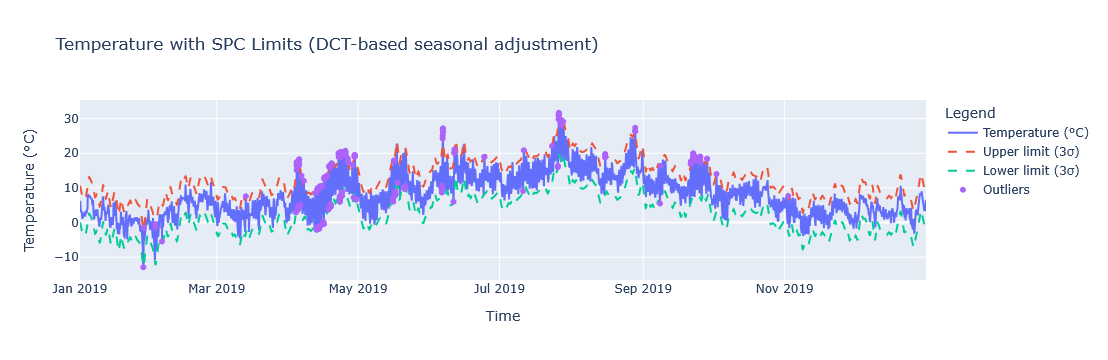

{'n_samples': 8760,
 'n_outliers': 192,
 'outlier_pct': 2.192,
 'params': {'cutoff': 0.05, 'n_sigma': 3, 'robust': True},
 'limits_satv': {'center': -0.1246207847119602,
  'sigma': 1.757084513831747,
  'upper_satv': 5.146632756783281,
  'lower_satv': -5.395874326207202}}

In [39]:
fig, summary = plot_temp_spc_plotly(df_bergen_2019, cutoff=0.05, n_sigma=3, robust=True)
fig.show()
summary


# 

### Plot the precipitation as a function of time

In [42]:
def plot_precip_lof_plotly(
    df: pd.DataFrame,
    time_col: str = "time",
    precip_col: str = "precipitation",
    contamination: float = 0.01,
    n_neighbors: int = 20,
):
    """
    Detect precipitation anomalies using the Local Outlier Factor (LOF) method,
    and return a Plotly interactive figure plus a summary dict.

    Parameters
    ----------
    df : DataFrame containing at least [time_col, precip_col]
    time_col : datetime column name (tz-aware or naive)
    precip_col : precipitation column name (mm)
    contamination : expected proportion of outliers (e.g., 0.01 = 1%)
    n_neighbors : number of neighbors for LOF (typical range: 10..50)

    Returns
    -------
    fig : plotly.graph_objects.Figure
    summary : dict with counts, percentages, parameters, and score ranges
    anomalies_df : DataFrame subset with detected anomalies (time + precipitation + lof_score)
    """

    # --- Extract series and ensure proper types ---
    s = pd.to_numeric(df[precip_col], errors="coerce")
    t = pd.to_datetime(df[time_col])
    mask_valid = s.notna()
    s = s[mask_valid].to_numpy().reshape(-1, 1)
    t_valid = t[mask_valid]

    n = s.shape[0]
    if n == 0:
        raise ValueError("Empty precipitation series after dropping NaNs.")

    # --- Scale the data robustly (LOF benefits from roughly comparable scales) ---
    scaler = RobustScaler()
    X = scaler.fit_transform(s)

    # --- Fit LOF (novelty=False for unsupervised outlier detection on training data) ---
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        novelty=False
    )
    labels = lof.fit_predict(X)           # -1 = outlier, +1 = inlier
    scores = lof.negative_outlier_factor_ # the lower, the more “outlying”

    is_outlier = labels == -1
    n_out = int(is_outlier.sum())
    outlier_pct = round(100.0 * n_out / n, 3)

    # --- Build figure ---
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=t_valid, y=s.ravel(), mode="lines", name="Precipitation (mm)"
    ))

    if n_out > 0:
        fig.add_trace(go.Scatter(
            x=t_valid[is_outlier], y=s.ravel()[is_outlier],
            mode="markers", name="LOF anomalies",
        ))

    fig.update_layout(
        title="Precipitation with LOF Anomalies",
        xaxis_title="Time",
        yaxis_title="Precipitation (mm)",
        legend_title="Legend",
        hovermode="x unified"
    )

    # --- Prepare outputs ---
    anomalies_df = pd.DataFrame({
        time_col: t_valid[is_outlier],
        precip_col: s.ravel()[is_outlier],
        "lof_score": scores[is_outlier],  # more negative = more anomalous
    }).sort_values("lof_score")  # most anomalous first

    summary = {
        "n_samples": n,
        "n_outliers": n_out,
        "outlier_pct": outlier_pct,
        "params": {"contamination": contamination, "n_neighbors": n_neighbors},
        "score_range": {"min": float(scores.min()), "max": float(scores.max())},
        "top5_anomalies": anomalies_df.head(5).to_dict(orient="records"),
    }

    return fig, summary, anomalies_df


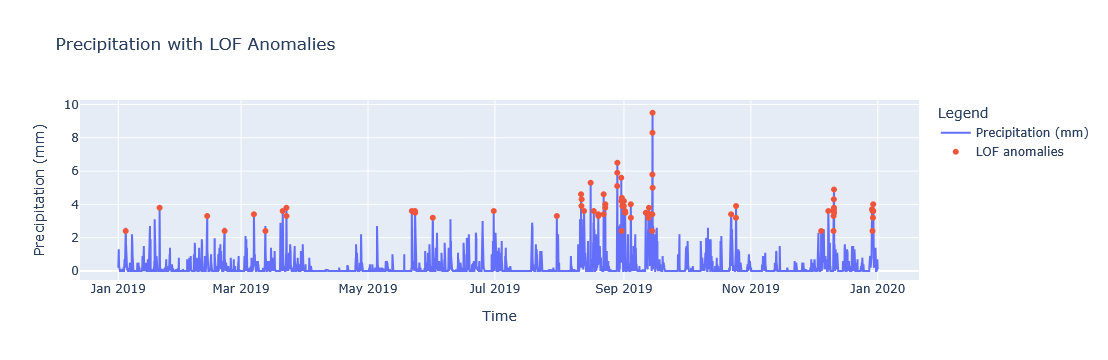

In [47]:
fig_p, summary_p, anomalies_p = plot_precip_lof_plotly(
    df_bergen_2019,
    n_neighbors=50,       # to reduce impact of duplicates
    contamination=0.01
)
fig_p.show()


# 

## STL 

In [53]:
def plot_stl_plotly(
    df: pd.DataFrame,
    price_area: str = "NO1",
    production_group: str = "hydro",
    period: int = 24*7,        # weekly seasonality on hourly data
    seasonal: int = 13,        # smoother for seasonal component
    trend: int = 101,          # smoother for trend component
    robust: bool = True,
    time_col: str = "start_time",
    value_col: str = "quantity_kwh",
    area_col: str = "price_area",
    group_col: str = "production_group",
):
    """
    STL decomposition (Seasonal-Trend using LOESS) on Elhub production data.

    Parameters
    ----------
    df : DataFrame with Elhub data (hourly)
          required columns: [area_col, group_col, time_col, value_col]
    price_area : e.g., "NO1" .. "NO5"
    production_group : e.g., "hydro", "wind", "thermal", etc.
    period : seasonal period length (in samples). For hourly data, 24*7 = weekly cycle.
    seasonal : seasonal smoother length (odd integer > 1)
    trend : trend smoother length (odd integer > 1)
    robust : use robust fitting (downweights outliers)
    time_col, value_col, area_col, group_col : column names

    Returns
    -------
    fig : Plotly Figure showing Observed / Trend / Seasonal / Residual
    res : statsmodels.tsa.seasonal.STLResult
    info : dict with basic metadata about the run
    """
    # --- 1) Filter selection (area + group) ---
    d = df[(df[area_col] == price_area) & (df[group_col] == production_group)].copy()
    if d.empty:
        raise ValueError(f"No rows for area={price_area}, group={production_group}")

    # --- 2) Time indexing & hourly regularization ---
    d[time_col] = pd.to_datetime(d[time_col], utc=True, errors="coerce")
    d = d.dropna(subset=[time_col]).sort_values(time_col)
    d = d.set_index(time_col)

    # If multiple rows per hour, aggregate (sum); if gaps, create full hourly index
    d = d[[value_col]].astype(float).groupby(level=0).sum()
    full_idx = pd.date_range(d.index.min(), d.index.max(), freq="h", tz=d.index.tz)
    d = d.reindex(full_idx)
    # Fill missing values: interpolate then fallback to 0 if any remaining NaN
    d[value_col] = d[value_col].interpolate(method="time", limit_direction="both")
    d[value_col] = d[value_col].fillna(0.0)

    y = d[value_col].to_numpy()

    # --- 3) STL decomposition ---
    stl = STL(y, period=period, seasonal=seasonal, trend=trend, robust=robust)
    res = stl.fit()

    # --- 4) Plotly figure with 4 panels ---
    fig = make_subplots(
        rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.06,
        subplot_titles=("Observed", "Trend", "Seasonal", "Residual")
    )
    t = d.index

    fig.add_trace(go.Scatter(x=t, y=res.observed, mode="lines", name="Observed"),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=t, y=res.trend, mode="lines", name="Trend"),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=t, y=res.seasonal, mode="lines", name="Seasonal"),
                  row=3, col=1)
    fig.add_trace(go.Scatter(x=t, y=res.resid, mode="lines", name="Residual"),
                  row=4, col=1)

    fig.update_layout(
        title=f"STL Decomposition — Area {price_area} · Group {production_group} "
              f"(period={period}, seasonal={seasonal}, trend={trend}, robust={robust})",
        height=800,
        hovermode="x unified",
        showlegend=False,
        xaxis4_title="Time",
        yaxis_title=value_col
    )

    info = {
        "price_area": price_area,
        "production_group": production_group,
        "n_samples": int(len(y)),
        "params": {
            "period": period, "seasonal": seasonal, "trend": trend, "robust": robust
        },
        "time_range": (str(t.min()), str(t.max())),
        "value_col": value_col,
    }

    return fig, res, info


#### Test with data from Mongo

In [54]:
# --- Load Elhub production data from MongoDB for STL analysis ---
from pymongo import MongoClient
from dotenv import load_dotenv
import os
import pandas as pd

load_dotenv()
uri = os.getenv("MONGO_URI")  # from .env
client = MongoClient(uri)
db = client["ind320"]
coll = db["production_mba_hour"]

# Fetch all documents
cursor = coll.find({}, {"_id": 0})  # exclude Mongo _id
df_elhub = pd.DataFrame(list(cursor))
client.close()

print("Loaded Elhub data from MongoDB")
print(df_elhub.shape)
print(df_elhub.head())


Loaded Elhub data from MongoDB
(215058, 4)
  price_area production_group          start_time  quantity_kwh
0        NO1            hydro 2020-12-31 23:00:00     2507716.8
1        NO1            hydro 2021-01-01 00:00:00     2494728.0
2        NO1            hydro 2021-01-01 01:00:00     2486777.5
3        NO1            hydro 2021-01-01 02:00:00     2461176.0
4        NO1            hydro 2021-01-01 03:00:00     2466969.2


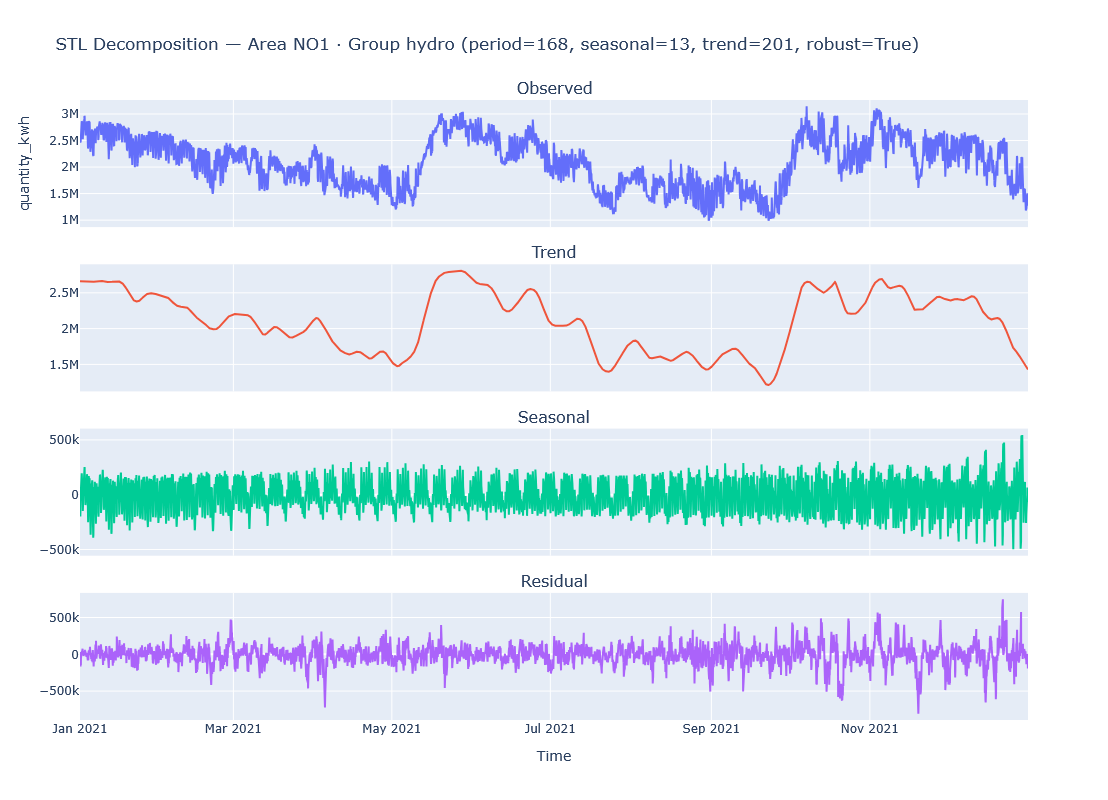

In [55]:
fig_stl, res_stl, info_stl = plot_stl_plotly(
    df_elhub,
    price_area="NO1",
    production_group="hydro",
    period=24*7,   # 168
    seasonal=13,   # impair, OK
    trend=201,     # impair et > 168 -> OK
    robust=True
)
fig_stl.show()


## Spectogram 

In [57]:
def plot_spectrogram_elhub(
    df: pd.DataFrame,
    price_area: str = "NO1",
    production_group: str = "hydro",
    time_col: str = "start_time",
    value_col: str = "quantity_kwh",
    area_col: str = "price_area",
    group_col: str = "production_group",
    window_len: int = 24*14,   # 2 weeks window on hourly data
    overlap: float = 0.5,      # 50% overlap
    detrend: str = "constant", # remove mean per segment
    scaling: str = "density",  # or "spectrum"
):
    """
    Spectrogram on Elhub production time series (hourly).
    Returns (fig, info).

    Parameters
    ----------
    df : DataFrame with columns [price_area, production_group, start_time, quantity_kwh]
    price_area, production_group : filters
    window_len : window length in samples (hours)
    overlap : fraction between 0 and <1 for segment overlap (e.g., 0.5)
    detrend : scipy.signal.spectrogram detrend option
    scaling : 'density' or 'spectrum'
    """
    # 1) Filter and regularize hourly series
    d = df[(df[area_col] == price_area) & (df[group_col] == production_group)].copy()
    if d.empty:
        raise ValueError(f"No rows for area={price_area}, group={production_group}")

    d[time_col] = pd.to_datetime(d[time_col], utc=True, errors="coerce")
    d = d.dropna(subset=[time_col]).sort_values(time_col).set_index(time_col)
    d = d[[value_col]].astype(float).groupby(level=0).sum()

    # full hourly index; pandas now prefers 'h'
    full_idx = pd.date_range(d.index.min(), d.index.max(), freq="h", tz=d.index.tz)
    d = d.reindex(full_idx)

    # fill gaps
    d[value_col] = d[value_col].interpolate(method="time", limit_direction="both").fillna(0.0)

    y = d[value_col].to_numpy()
    n = len(y)
    if n < max(window_len, 64):
        raise ValueError(f"Series too short ({n} pts) for window_len={window_len}")

    # 2) Spectrogram (fs = 1 sample/hour)
    fs = 1.0  # cycles per hour
    nperseg = int(window_len)
    noverlap = int(np.clip(overlap, 0.0, 0.95) * nperseg)
    noverlap = min(noverlap, nperseg - 1)  # must be < nperseg

    f, t_bins, Sxx = spectrogram(
        y, fs=fs, window="hann", nperseg=nperseg, noverlap=noverlap,
        detrend=detrend, scaling=scaling, mode="psd"
    )
    # Frequencies currently in cycles/hour; convert to cycles/day for readability
    f_per_day = f * 24.0
    # Time bins are offsets in hours from start; map to timestamps
    t0 = d.index[0]
    t_stamps = t0 + pd.to_timedelta(t_bins, unit="h")

    # 3) Plotly heatmap
    fig = go.Figure(data=go.Heatmap(
        x=t_stamps, y=f_per_day, z=10*np.log10(Sxx + 1e-12),  # dB scale
        coloraxis="coloraxis", zsmooth=False
    ))
    fig.update_layout(
        title=f"Spectrogram — Area {price_area} · Group {production_group} "
              f"(window={nperseg}h, overlap={int(overlap*100)}%)",
        xaxis_title="Time",
        yaxis_title="Frequency (cycles/day)",
        hovermode="x unified",
        coloraxis=dict(colorbar=dict(title="Power (dB)"))
    )

    # 4) Summary info (top spectral peaks)
    # Peak at each time slice (argmax over frequency)
    peak_idx = np.argmax(Sxx, axis=0)
    peak_freq_per_day = f_per_day[peak_idx]
    info = {
        "n_samples": n,
        "time_range": (str(d.index.min()), str(d.index.max())),
        "window_len_hours": nperseg,
        "overlap": overlap,
        "dominant_freq_per_day": {
            "median": float(np.median(peak_freq_per_day)),
            "p10": float(np.percentile(peak_freq_per_day, 10)),
            "p90": float(np.percentile(peak_freq_per_day, 90)),
        },
        "notes": "Peaks around ~1 c/d indicate strong daily cycle; ~1/7 c/d indicates weekly cycle.",
    }

    return fig, info


### Test

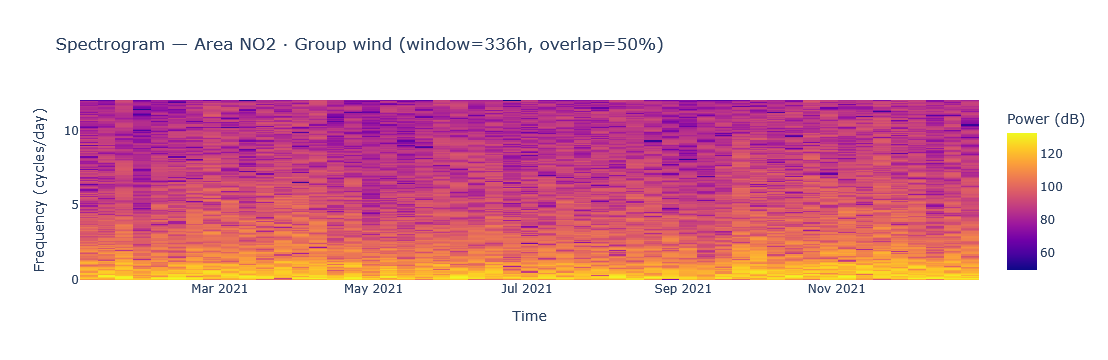

In [61]:
fig_spec, info_spec = plot_spectrogram_elhub(
    df_elhub,
    price_area="NO2",
    production_group="wind",
    window_len=24*14,
    overlap=0.5
)
fig_spec.show()


## Project Log 

For this part, I started by creating a new GitHub branch called **part3** and a new notebook to avoid breaking anything that had already been validated. I set up a clear structure (**Setup, Cities, API, Outliers, STL, Spectrogram, Log**), which helped me know exactly where to put each step.

On the setup side, I ran into a small issue with the **.env** file: I was using `MONGODB_URI` in the code while my variable was actually named `MONGO_URI`. After correcting it and reloading with `load_dotenv`, the connection to MongoDB Atlas returned “ping ok.”
I also checked access to the weather API: the correct URL for ERA5 is **[https://archive-api.open-meteo.com/v1/era5](https://archive-api.open-meteo.com/v1/era5)** (not the old endpoint). A test over 24–48 hours confirmed that the response was coming through properly.

Next, I built a **DataFrame** of the five Norwegian cities (Oslo, Kristiansand, Trondheim, Tromsø, Bergen) with their coordinates to link them to the price zones **NO1–NO5**.
I wrote a function to download ERA5 data for a full year based on latitude and longitude. I tested it on **Bergen 2019** and got around **8,760 hours**, with no missing values.
I then compared the column schema with my CSV from part 1 and aligned the column names (without units in the headers) to keep the format simple and consistent.

For **temperature**, I applied a **high-pass DCT filter** to remove seasonality and keep only the “fast” variations. From this adjusted series, I set **SPC bounds** (median/MAD by default) and highlighted in red the points detected as outliers.
The final plot was done in **Plotly** to keep it interactive.

For **precipitation**, I used **LOF (Local Outlier Factor)**. Since there are many zeros (duplicates), I increased `n_neighbors` to stabilize detection. The result is also a Plotly chart with the anomalies highlighted.

Finally, I retrieved **Elhub data** from MongoDB and performed an **STL decomposition (LOESS)** with adjustable parameters (weekly period in hourly data, smoothing, robust option).
I fixed two details: the hourly Pandas frequency (`freq="h"`) and the **STL constraint** that requires the trend window to be greater than the period (I set it to 201 when period=168).
I also added a **spectrogram** (window, overlap) to visualize the dominant cycles (daily ≈ 1 cycle/day, weekly ≈ 1/7).
Everything is designed to be reused later in **Streamlit** (pages “new A” and “new B”).

Overall, this part helped me gain better control over data quality (outliers/anomalies) and develop a deeper understanding of cycles and trends within the time series.
